# 1. 모델 전처리

In [1]:
import os
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

2023-12-11 00:24:56.050753: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 00:24:56.079171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 00:24:56.079212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 00:24:56.079927: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 00:24:56.084431: I tensorflow/core/platform/cpu_feature_guar

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

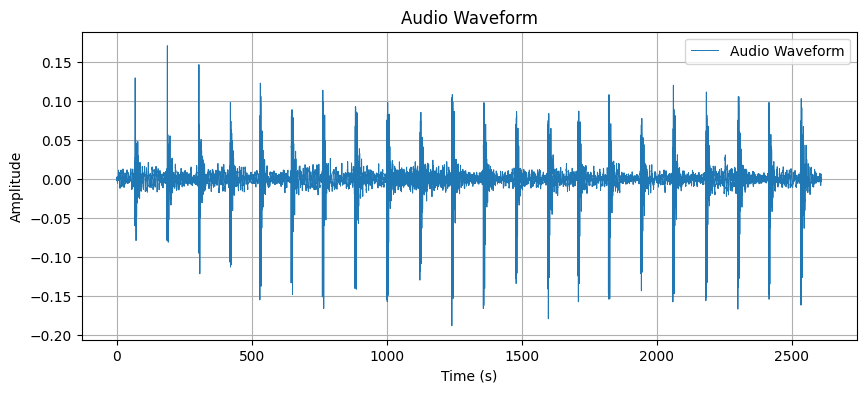

In [3]:
# 오디오 출력
audio_file_path = './dataset/4-1.wav'

# Load the audio file
y, sr = librosa.load(audio_file_path)
# Create a time axis
time = librosa.times_like(y)
# Plot the audio waveform
plt.figure(figsize=(10, 4))
plt.plot(time, y, label='Audio Waveform', linewidth=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.legend()
plt.grid()
plt.show()

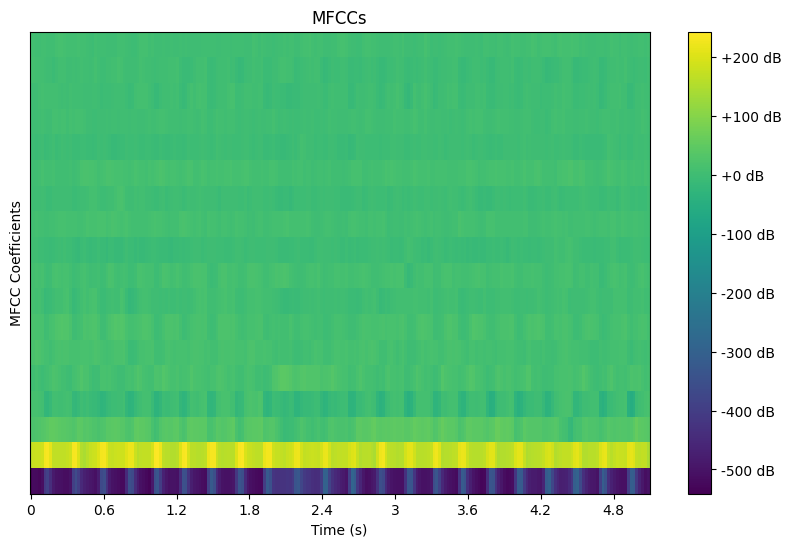

In [4]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=18)
time = librosa.times_like(mfccs)

# Display the MFCCs as a graph
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfccs, x_axis='time', sr=sr, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCCs')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.show()

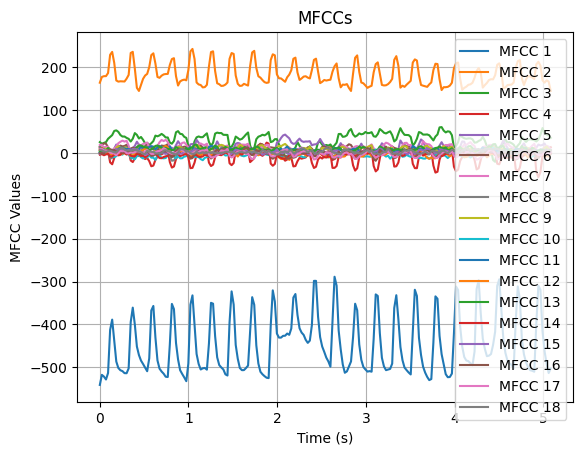

In [5]:
for i in range(mfccs.shape[0]):
    plt.plot(time, mfccs[i], label=f'MFCC {i + 1}')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Values')
plt.title('MFCCs')
plt.legend()
plt.grid()
plt.show()

In [6]:
def preprocess_mfcc(audio_file_path, n_mfcc=18, fixed_length=200):
    # Load the audio file
    y, sr = librosa.load(audio_file_path)
    
    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    # Pad or truncate MFCCs to the fixed length
    if mfccs.shape[1] < fixed_length:
        mfccs_padded = np.pad(mfccs, ((0, 0), (0, fixed_length - mfccs.shape[1])), mode='constant')
    elif mfccs.shape[1] > fixed_length:
        mfccs_padded = mfccs[:, :fixed_length]
    else:
        mfccs_padded = mfccs
    
    return mfccs_padded

In [7]:
from sklearn.model_selection import train_test_split
# Load the CSV file containing filenames and labels
dataset_directory = './dataset/'
csv_file_path = 'audio_filenames.csv'
df = pd.read_csv(csv_file_path)

# Load MFCC data for each audio file and preprocess it
mfcc_data = []
for filename in df['Filename']:
    # Load and preprocess MFCC data for the audio file (replace with your preprocessing code)
    mfcc = preprocess_mfcc(dataset_directory+filename)
    mfcc_data.append(mfcc)

# Create NumPy arrays for MFCC data and labels
X = np.array(mfcc_data)
y = df['Label'].values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)
# You can print the shapes to verify the split
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (259, 18, 200)
X_val shape: (65, 18, 200)
y_train shape: (259,)
y_val shape: (65,)


# 2. 모델 학습

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [9]:
'''
# Define the CNN model
model = Sequential()

# Add a 2D Convolutional layer with 32 filters, a 3x3 kernel, and 'relu' activation
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(18, 200, 1)))

# Add a MaxPooling layer
model.add(MaxPooling2D((2, 2)))
# Add Dropout with a rate of 0.2
model.add(Dropout(0.2))

# Add another 2D Convolutional layer with 64 filters, a 3x3 kernel, and 'relu' activation
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another MaxPooling layer
model.add(MaxPooling2D((2, 2)))
# Add Dropout with a rate of 0.2
model.add(Dropout(0.2))

# Add a third 2D Convolutional layer with 128 filters, a 3x3 kernel, and 'relu' activation
model.add(Conv2D(128, (3, 3), activation='relu'))

# Flatten the output for fully connected layers
model.add(Flatten())

# Add a Dense layer with 128 units and 'relu' activation
model.add(Dense(128, activation='relu'))

# Add the output layer with as many units as classes and 'softmax' activation
model.add(Dense(1, activation='sigmoid'))

# Compile the model with appropriate loss, optimizer, and metrics
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
'''

# Define the CNN model
model = Sequential()

# Add a 2D Convolutional layer with 32 filters, a 2x2 kernel, 'relu' activation, and padding
model.add(Conv2D(32, (2, 2), activation='relu', input_shape=(18, 200, 1), padding='same'))
# Add a MaxPooling layer
model.add(MaxPooling2D((2, 2)))
# Add Dropout with a rate of 0.2
model.add(Dropout(0.2))

# Add another 2D Convolutional layer with 64 filters, a 2x2 kernel, 'relu' activation, and padding
model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
# Add another MaxPooling layer
model.add(MaxPooling2D((2, 2)))
# Add Dropout with a rate of 0.2
model.add(Dropout(0.2))

# Add a third 2D Convolutional layer with 128 filters, a 2x2 kernel, 'relu' activation, and padding
model.add(Conv2D(128, (2, 2), activation='relu', padding='same'))
# Add another MaxPooling layer
model.add(MaxPooling2D((2, 2)))
# Add Dropout with a rate of 0.2
model.add(Dropout(0.2))

# ---------------------------------- TEST -------------------------------------------------
# Add a fourth 2D Convolutional layer with 128 filters, a 2x2 kernel, 'relu' activation, and padding
model.add(Conv2D(256, (2, 2), activation='relu', padding='same'))
# Add another MaxPooling layer
model.add(MaxPooling2D((2, 2)))
# Add Dropout with a rate of 0.2
model.add(Dropout(0.2))

# Add a fifth 2D Convolutional layer with 128 filters, a 2x2 kernel, 'relu' activation, and padding
model.add(Conv2D(512, (2, 2), activation='relu', padding='same'))
# Add Dropout with a rate of 0.2
model.add(Dropout(0.2))
# ---------------------------------- TEST -------------------------------------------------

# Flatten the output for fully connected layers
model.add(Flatten())

# Add a Dense layer with 128 units and 'relu' activation
model.add(Dense(128, activation='relu'))

# Add the output layer with 1 unit and 'sigmoid' activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with appropriate loss, optimizer, and metrics
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

2023-12-11 00:25:02.786055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1072 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 200, 32)       160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 100, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 9, 100, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 100, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 50, 64)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 50, 64)         0

In [10]:
# 모델 최적화를 위한 설정 구간입니다.
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./model/WATERMELON_CNN-5.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, validation_split=0.25, epochs=200, batch_size=128, verbose=1, callbacks=[early_stopping_callback,checkpointer])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_val, y_val)[1]))

Epoch 1/200


2023-12-11 00:25:03.821191: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-11 00:25:03.967151: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-11 00:25:04.036584: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-11 00:25:04.384125: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-11 00:25:05.502339: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1815e22c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-11 00:25:05.502367: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Com

1/2 [==============>...............] - ETA: 5s - loss: 2.3808 - accuracy: 0.5703

2023-12-11 00:25:10.453198: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 834.95MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-11 00:25:10.544381: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 834.95MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2/2 [==============================] - ETA: 0s - loss: 21.5151 - accuracy: 0.5773
Epoch 1: val_loss improved from inf to 6.25022, saving model to ./model/WATERMELON_CNN-5.hdf5
2/2 [==============================] - 8s 3s/step - loss: 21.5151 - accuracy: 0.5773 - val_loss: 6.2502 - val_accuracy: 0.6154
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 17.5493 - accuracy: 0.5703
Epoch 2: val_loss improved from 6.25022 to 0.80755, saving model to ./model/WATERMELON_CNN-5.hdf5
2/2 [==============================] - 0s 73ms/step - loss: 12.1725 - accuracy: 0.5670 - val_loss: 0.8076 - val_accuracy: 0.4000
Epoch 3/200
1/2 [==============>...............] - ETA: 0s - loss: 1.2368 - accuracy: 0.5391
Epoch 3: val_loss improved from 0.80755 to 0.75971, saving model to ./model/WATERMELON_CNN-5.hdf5


/home/t23304/.local/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 75ms/step - loss: 1.2182 - accuracy: 0.5206 - val_loss: 0.7597 - val_accuracy: 0.3846
Epoch 4/200
1/2 [==============>...............] - ETA: 0s - loss: 1.0261 - accuracy: 0.4531
Epoch 4: val_loss improved from 0.75971 to 0.69212, saving model to ./model/WATERMELON_CNN-5.hdf5
2/2 [==============================] - 0s 68ms/step - loss: 1.0079 - accuracy: 0.4536 - val_loss: 0.6921 - val_accuracy: 0.5846
Epoch 5/200
1/2 [==============>...............] - ETA: 0s - loss: 0.6793 - accuracy: 0.6250
Epoch 5: val_loss improved from 0.69212 to 0.67831, saving model to ./model/WATERMELON_CNN-5.hdf5
2/2 [==============================] - 0s 73ms/step - loss: 0.6749 - accuracy: 0.6289 - val_loss: 0.6783 - val_accuracy: 0.6154
Epoch 6/200
1/2 [==============>...............] - ETA: 0s - loss: 0.6642 - accuracy: 0.5938
Epoch 6: val_loss improved from 0.67831 to 0.66053, saving model to ./model/WATERMELON_CNN-5.hdf5
2/2 [==============================] - 0s 6

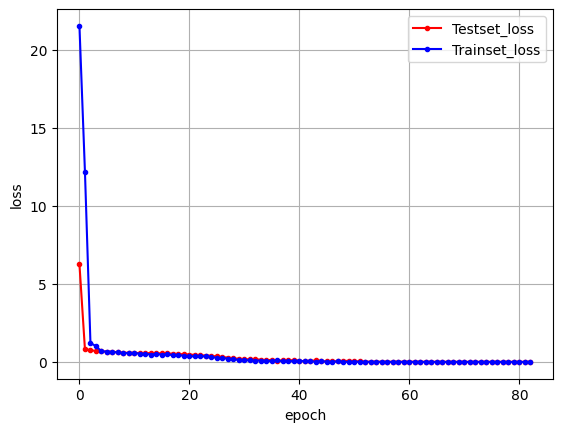

In [11]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()